## Convergence rate

In order to find the convergence rate we will use a larger dataset than the locks of a person from the previous sample. The users of the previous sample had made 60 locks each and for such a task we need a larger dataset. For that we have the locks of 'Giorgos', which are 590 in numbers and have been sampled during 4 sampling sessions in 4 diferent days.

These locks will be the training class and the class that we will use to evaluate them will be all the 16 other participants from who we have combined 1088 locks (at least 60 for each person). After loading the data, with this notebook we can use the models that we have been using for the previous testing. A selected model, a selected parameters and a selected group of features need to be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output

# Pretty display for notebooks
%matplotlib inline

random_state = 0

rows_each = 60

zoom = 40 # number of samples for shorter plot

# specify the place from where we will use the data
source_path_features_rel = 'data/Main collection - features/'

# specify the target path for the two feature selections
source_path_parameters_rel = 'data/Main collection - results/parameters/'

# path to drop logs
logs_path = 'data/Main collection - results/logs/'

# path to save images
img_save_path = 'data/Main collection - results/images/'

# find the file names in the directory
feature_files = os.listdir(source_path_features_rel)

# remove the readme, and the Giorgos files
feature_files.remove('README.md')
feature_files.remove('best ratios by multiclass RF')

print("The number of files in the directory is {}.".format(len(feature_files)))

The number of files in the directory is 20.


In [2]:
# DEBUGGING OPTIONS
np.set_printoptions(threshold=80)
pd.set_option('display.max_rows', 8)
pd.set_option('display.max_columns', 8)

In [3]:
np.set_printoptions(threshold=40000)

### Load the two dataframes (Positive and Negative)

The locks from Giorgos are loaded into a X_Pos dataframe, and the locks of all others to X_neg.

In [4]:
# initialize the two data frames
X_pos = pd.DataFrame()
X_neg = pd.DataFrame()

for i, file in enumerate(feature_files):
    
    # read each features file into a df
    df = pd.read_csv(source_path_features_rel+file)

    if file[:7]=='Giorgos':
    
        # add the data to the bigger dataframe
        X_pos = pd.concat([X_pos, df.loc[:, :]], ignore_index=True)
        
    else:
        
        # add the data to the bigger dataframe
        X_neg = pd.concat([X_neg, df.loc[:, :]], ignore_index=True)
            
# # create the labels
# y_pos = pd.Series([1] * X_pos.shape[0])
# y_neg = pd.Series([-1] * X_neg.shape[0])

print("The dataframe that holds the positive data is:")
display(X_pos)
print("The dataframe that holds the negative data is:")
display(X_neg)

print("The dataframe that holds the positive data has {} rows."
      .format(X_pos.shape[0]))
print("The dataframe that holds the negative data has {} rows."
      .format(X_neg.shape[0]))
# print("The dataframe that holds the positive data has {} rows. The labels are also {}."
#       .format(X_pos.shape[0], y_pos.shape[0]))
# print("The dataframe that holds the negative data has {} rows. The labels are also {}."
#       .format(X_neg.shape[0], y_neg.shape[0]))

The dataframe that holds the positive data is:


,AB_mil,AB_xyz,AB|AC_mil,AB|AC_xyz,...,zSpeed_range,zSpeed_skew,zSpeed_std,zSpeed_var
0,466.0,253.970652,0.584693,0.872127,...,0.627355,-0.245034,0.121704,0.014812
1,398.0,240.512798,0.521625,0.886715,...,0.939394,0.043945,0.186034,0.034609
2,432.0,254.703376,0.539326,0.846123,...,1.029412,-0.054730,0.148299,0.021993
3,377.0,264.502396,0.530986,0.832483,...,0.579044,0.334238,0.118313,0.013998
...,...,...,...,...,...,...,...,...,...
586,399.0,341.697595,0.520888,0.819731,...,2.261345,0.242707,0.254769,0.064907
587,400.0,360.337012,0.630915,0.809059,...,1.511785,0.009818,0.215901,0.046613
588,500.0,294.727085,0.651042,0.830067,...,1.380159,0.018743,0.178159,0.031741
589,572.0,395.393654,0.633444,0.884168,...,1.729602,-0.614441,0.199163,0.039666


The dataframe that holds the negative data is:


,AB_mil,AB_xyz,AB|AC_mil,AB|AC_xyz,...,zSpeed_range,zSpeed_skew,zSpeed_std,zSpeed_var
0,396.0,252.701121,0.458333,0.828064,...,0.568627,-0.594368,0.116893,0.013664
1,400.0,212.178240,0.546448,0.768307,...,0.725183,-0.937534,0.136206,0.018552
2,366.0,194.913846,0.549550,0.741623,...,0.617424,-0.689866,0.119564,0.014296
3,337.0,252.835331,0.559801,0.755625,...,0.786765,0.017139,0.144460,0.020869
...,...,...,...,...,...,...,...,...,...
1084,349.0,131.534736,0.536098,0.874446,...,0.656250,-0.122812,0.146899,0.021579
1085,371.0,116.349749,0.516713,0.830720,...,0.570565,0.107223,0.123287,0.015200
1086,433.0,127.818122,0.619456,0.855851,...,0.653595,-0.511291,0.121027,0.014648
1087,499.0,142.066840,0.677989,0.840469,...,0.718360,0.347184,0.120242,0.014458


The dataframe that holds the positive data has 590 rows.
The dataframe that holds the negative data has 1088 rows.


### Model initialization

In the next cells we will: 
1. set a number for training positive samples and a number for testing positive samples
2. load the parameters,
3. initialize the models we will be using (with the parameters),
4. load the feature groups

In [5]:
from sklearn import svm
from sklearn.ensemble import IsolationForest

In [6]:
num_train_positive_samples = 400
num_test_positive_samples = X_pos.shape[0] - num_train_positive_samples

print("The number of positive samples that is used for train is {} and for test {}."
      .format(num_train_positive_samples, num_test_positive_samples))

The number of positive samples that is used for train is 400 and for test 190.


In [7]:
# set the common name all files share
file_name = source_path_parameters_rel+'Optimal Parameters --- '

# load parameters
optimal_params_OCSVM = pd.read_csv(file_name+'one-class SVM.csv', nrows=5, 
                                   index_col=0, squeeze=True)
optimal_params_IF = pd.read_csv(file_name+'Isolation Forest.csv', nrows=4, 
                                index_col=0, squeeze=True)

In [8]:
# initialize the one-class SVM
clf_OCSVM = svm.OneClassSVM(kernel=optimal_params_OCSVM['kernel'], 
                            nu=float(optimal_params_OCSVM['nu']), 
                            degree=float(optimal_params_OCSVM['degree']),
                            gamma=float(optimal_params_OCSVM['gamma']),
                            coef0=float(optimal_params_OCSVM['coef0']))

# name the IF classifier
clf_OCSVM_name = 'one-class SVM'

# initialize the Isolation Forest
clf_IF = IsolationForest(n_estimators=int(optimal_params_IF['n_estimators']), 
                         max_samples=float(optimal_params_IF['max_samples']), 
                         contamination=float(optimal_params_IF['contamination']),
                         max_features=float(optimal_params_IF['max_features']), 
                         bootstrap=False, 
                         n_jobs=-1, 
                         random_state=random_state, 
                         verbose=0)

# name the IF classifier
clf_IF_name = 'Isolation Forest'

In [9]:
def loadRatioFeatureIds(file_name, n=30):
    """ Loads the file with features. """
    df = pd.read_csv('data/Main collection - features/best ratios by multiclass RF/' + file_name)
    return df.loc[:n-1, 'feature id']

In [10]:
def findMagnitudes(f1, f2):
    """ Selects the features for both f1 and f2 lists that start with mag. """
    ff = [f for f in f1 if f[:3]=='mag']
    ff.extend([f for f in f2 if f[:3]=='mag'])
    return ff

In [11]:
# get all the features
all_features = X_pos.columns.values.tolist()

# find all positional features
pos_features = [f for f in all_features if f[1:4]=='Pos' and f[4]!='I']

# find all position intervals
posInc_features = [f for f in all_features if f[1:7]=='PosInc' or f[3:9]=='PosInc']

# find all speed intervals
speed_features = [f for f in all_features if f[1:6]=='Speed' or f[3:8]=='Speed']

# find all x axis features
x_features_pos_posInc_speed = [f for f in pos_features if f[0]=='x'] + \
                                [f for f in posInc_features if f[0]=='x'] + \
                                [f for f in speed_features if f[0]=='x']

# find all y axis features
y_features_pos_posInc_speed = [f for f in pos_features if f[0]=='y'] + \
                                [f for f in posInc_features if f[0]=='y'] + \
                                [f for f in speed_features if f[0]=='y']

# find all z axis features
z_features_pos_posInc_speed = [f for f in pos_features if f[0]=='z'] + \
                                [f for f in posInc_features if f[0]=='z'] + \
                                [f for f in speed_features if f[0]=='z']

# find all magnitude features
magnitude_features = findMagnitudes(posInc_features, speed_features)

# combine best overall features
best_overall_features = x_features_pos_posInc_speed + y_features_pos_posInc_speed

# combine all overall features
all_overall_features = pos_features + posInc_features + speed_features

## Distances next ##

# find all euclidean distances
euc_dist_features = [f for f in all_features if f[2]=='_' and f[-3:]=='xyz']

# find all temporal distances
mil_dist_features = [f for f in all_features if f[2]=='_' and f[-3:]=='mil']

# combine euc and mil distances
all_distances = euc_dist_features + mil_dist_features

## Ratios next ##

# find the selected euclidean ratios
euc_all_ratio_features = [f for f in all_features if f[2]=='|' and f[-3:]=='xyz']

# find the selected temporal ratios
mil_all_ratio_features = [f for f in all_features if f[2]=='|' and f[-3:]=='mil']

# combine euc and temp ratios
all_ratio_features = euc_all_ratio_features + mil_all_ratio_features

## best ratios ##

# find the selected euclidean ratios
euc_best_ratio_features = loadRatioFeatureIds('Euclidean distance ratios.csv')

# find the selected temporal ratios
mil_best_ratio_features = loadRatioFeatureIds('Temporal distance ratios.csv')

# all best ratio features
all_best_ratio_features = pd.concat([euc_best_ratio_features, 
                                     mil_best_ratio_features], 
                                    ignore_index=True)

## Best all next ##

## best Combinations ##
best_overall_distances = best_overall_features + all_distances
best_overall_ratios = best_overall_features + list(all_best_ratio_features)
best_ratios_distances = list(all_best_ratio_features) + all_distances
best_overall_distances_ratios = best_overall_features + all_distances + list(all_best_ratio_features)

## best Combinations ## (2 - unused)
pos_with_distances = pos_features + all_distances
pos_with_best_ratios = pos_features + list(all_best_ratio_features)
pos_with_distances_with_best_ratios = pos_features + all_distances + list(all_best_ratio_features)

# all features
#all_features

### Model and Features Selection

In the next cell we will make a selection of the above models and features to make a convergence graph. For consistency with previous notebooks, the names for the feature set that have been used are:

    'positions', 'position intervals', 'speed intervals', 
    'x_pos_posInt_speed', 'y_pos_posInt_speed', 'z_pos_posInt_speed', 'magnitudes',
    'best_overall', 'all_overall',
    'euclidean distances', 'temporal distances', 'all_distances',
    'all euclidean ratios', 'all temporal ratios', 'all ratio features',
    'best euclidean ratios', 'best temporal ratios', 'all best ratios',
    'best overall distances', 'best overall ratios', 'best ratios distances', 
        'best overall dist ratios',
    'pos with distances', 'pos with best ratios', 'pos_distances_best_ratios',
    'all features'

In [12]:
# Feature set selection
selected_features_set = pos_with_distances
# Feature set name selection
name_of_selected_features_set = 'pos with distances'

### Convergence Graph

In order to produce the convergence graph we will make a plotting function and a function that calculates the x and y of the convergence line.

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [14]:
# style
plt.style.use('bmh')

def plotErrorToSampleCounts(x, y1, y2, y3, feature_set_name, classifier_name, 
                            num_samples, zoom='', saving_path=''):
    """ Plots a convergence line of a given feature set and classifier. """
    
    if zoom:
        num_samples=zoom
        zoom = '(first 40)'
    
    # init the figure and the axes object
    fig, ax = plt.subplots(1, 1)
    fig.set_tight_layout(False)

    # adjust the size of the figure
    fig.set_figwidth(6)
    fig.set_figheight(6)
        
    # plot df1 points
    ax.plot(x, y1, linewidth=1, color='red')#, linestyle='dashed'
    ax.plot(x, y2, linewidth=1, color='orange')#, linestyle='dashed'
    ax.plot(x, y3, linewidth=1, color='green')#, linestyle='dashed'
    
    # set text axes
    ax.set_title("Convergence rate of {} on '{}' features"
                 .format(classifier_name, feature_set_name)+'\n'+zoom) if not saving_path else None
    ax.set_xlabel('number of training samples')
    ax.set_ylabel('scores')
    # set limits in axis
    ax.set_xlim([0, num_samples])
    ax.set_ylim([0, 1])
    
    # set the legend
    ax.legend(['False Negatiives', 'False Positives', 'AUC'], shadow=True)
    
    # save or show
    if saving_path:
        fig.savefig("{}/Error against number of training samples of {} on '{}' features{}"
                    .format(saving_path, classifier_name, feature_set_name, zoom)+'.png', bbox_inches='tight') 
    else:
        plt.show()
        
    # close the image
    plt.close()

In [15]:
def findFalseNegatives(pred):
    """ Finds the False Negatives in a prediction of only positive samples. """
    # get the unique predicted labels and their counts in a dictionary
    unique_counts = dict(zip(*np.unique(pred, return_counts=True)))
    # find the correct predictions
    num_correct_predictions = unique_counts[-1] if -1 in unique_counts else 0
    #return the ratio
    return num_correct_predictions / sum(unique_counts.values()) * 100

In [16]:
def findFalsePositives(pred):
    """ Finds the False Positives in a prediction of only negative samples. """
    # get the unique predicted labels and their counts in a dictionary
    unique_counts = dict(zip(*np.unique(pred, return_counts=True)))
    # find the correct predictions
    num_correct_predictions = unique_counts[1] if 1 in unique_counts else 0
    #return the ratio
    return num_correct_predictions / sum(unique_counts.values()) * 100

In [17]:
def classify(X_train_pos, X_test_pos, X_test_neg, clf, scaler):
    """ Finds the convergence line of a classifier, in different samples. """
    
    # fit the scalar
    scaler.fit(X_train_pos)

    # scale all data before fitting the classifier or making predictions
    X_train_pos_transformed = scaler.transform(X_train_pos)
    X_test_pos_transformed = scaler.transform(X_test_pos)
    X_test_neg_transformed = scaler.transform(X_test_neg)
            
    # fit the classifier
    clf.fit(X_train_pos_transformed)

    # make predictions on Positive data
    prediction_Pos = clf.predict(X_test_pos_transformed)
    prediction_Pos_DF = clf.decision_function(X_test_pos_transformed)
    # make predictions on Negative data
    prediction_Neg = clf.predict(X_test_neg_transformed)
    prediction_Neg_DF = clf.decision_function(X_test_neg_transformed)

#     print("The positive labels are predicted as: \n{}"
#           .format([*zip(prediction_Pos, prediction_Pos_DF)]))
#     print("The positive labels are predicted as: \n{}".format(prediction_Pos))
#     print("The positive distances from the decision boundaries are found as: \n{}"
#           .format(prediction_Pos_DF))
#     print("The negative labels are predicted as: \n{}"
#           .format([*zip(prediction_Neg, prediction_Neg_DF)]))
#     print("The negative labels are predicted as: \n{}".format(prediction_Neg))
#     print("The negative distances from the decision boundaries are found as: \n{}"
#           .format(prediction_Neg_DF))
#     print()
#     print("----------------------------------------------------------------------------")
#     print("----------------------------------------------------------------------------")
#     print("----------------------------------------------------------------------------")
#     print()

    # find the false negatives of the split and save to the array
    FN_rate = findFalseNegatives(prediction_Pos)
    # find the false positives
    FP_rate = findFalsePositives(prediction_Neg)
        
#     # find the True Positives according to False Negatives
#     TP_rate = 1-FN
#     # find the True Negatives according to False Positives
#     TN_rate = 1-FP

    # get the true labels and their scores
#     y_true = [1 for _ in range(prediction_Pos_DF.shape[0])] + [-1 for _ in range(prediction_Neg_DF.shape[0])]
#     y_scores = [s for s in prediction_Pos_DF] + [s for s in prediction_Neg_DF]
    y_true = [-1 for _ in range(prediction_Neg_DF.shape[0])] + [1 for _ in range(prediction_Pos_DF.shape[0])]
    y_scores = [s for s in prediction_Neg_DF] + [s for s in prediction_Pos_DF]

    #
    auc_score = roc_auc_score(y_true, y_scores)
    
    return FN_rate, FP_rate, auc_score

In [18]:
def findConvergencePoints(X_mix_pos, X_test_neg, samples, clf, num_test_samples, repetitions):
    """ Finds the convergence line of a classifier, in different samples. """
    
    scores_FN, scores_FP, scores_AUC = [], [], []
    
    # initialize a minmax scalar
    scaler = MinMaxScaler()
        
    for s in samples:
        
        clear_output()
        print("-- tracker: Working on training sample size of {}".format(s))
        
        FNs, FPs, AUCs = [], [], []
        
        for rep in range(repetitions):
            
            state = rep
            
            # select a sample of 60 values (without replacement)
            X_train_pos_sampled = X_mix_pos.sample(n=s, random_state=state, axis=0)
            
            # find the sampled indices
            train_indices = X_mix_pos.index.isin(X_train_pos_sampled.index.values)
            
            # sample again excluding the already sampled indices
            X_test_pos_sampled = X_mix_pos.loc[~train_indices, :].sample(n=num_test_samples, 
                                                                         random_state=state, 
                                                                         axis=0)

            # sort the sampled dataframe by index 
            X_train_pos_sampled.index = range(X_train_pos_sampled.shape[0])

            # sort the sampled dataframe by index 
            X_test_pos_sampled.index = range(X_test_pos_sampled.shape[0])

            # get a score for 
            FN, FP, AUC = classify(X_train_pos_sampled, X_test_pos_sampled, X_test_neg, clf, scaler)
            
            FNs.append(FN)   # add it to the FNs for all repetitions
            FPs.append(FP)   # add it to the FPs for all repetitions
            AUCs.append(AUC) # add it to the AUCs for all repetitions
            
#         print("The FNs are: {}".format(FNs))
#         print("The FPs are: {}".format(FPs))
#         print()

        scores_FN.append(np.mean(FNs))   # add it to the FN scores that corresponds to samples list
        scores_FP.append(np.mean(FPs))   # add it to the FP scores that corresponds to samples list
        scores_AUC.append(np.mean(AUCs)) # add it to the AUC scores that corresponds to samples list
        
    return scores_FN, scores_FP, scores_AUC

### Run the Models - one-class SVM

In the next cell we will be running the models for one-class SVM in line with all the previous specifications, and then we will put the plots in the graph.

In [19]:
# initialize the sumber of samples
samples_OCSVM = list(range(1, num_train_positive_samples+1))
#samples_OCSVM = list(range(1, 41))

# select a repetitions parameter for the time each point is calculated
reps_OCSVM = 20

# get the FN and FP scores
scores_FN_OCSVM, scores_FP_OCSVM, scores_AUC_OCSVM = \
                        findConvergencePoints(X_pos.loc[:, selected_features_set],
                                              X_neg.loc[:, selected_features_set],
                                              samples_OCSVM,
                                              clf_OCSVM,
                                              num_test_positive_samples,
                                              reps_OCSVM)

-- tracker: Working on training sample size of 400


In [20]:
scores_FN_OCSVM = [score*0.01 for score in scores_FN_OCSVM]
scores_FP_OCSVM = [score*0.01 for score in scores_FP_OCSVM]

# make a dataframe out of the data to log it
scores_OCSVM_df = pd.DataFrame({'samples': samples_OCSVM,
                                'FN_score': scores_FN_OCSVM,
                                'FP_score': scores_FP_OCSVM,
                                'AUC_score': scores_AUC_OCSVM})

# save the df
scores_OCSVM_df.to_csv(logs_path + "convergence experiment with Giorgos data on {} and '{}' features.csv"
                       .format(clf_OCSVM_name, name_of_selected_features_set), index=False)

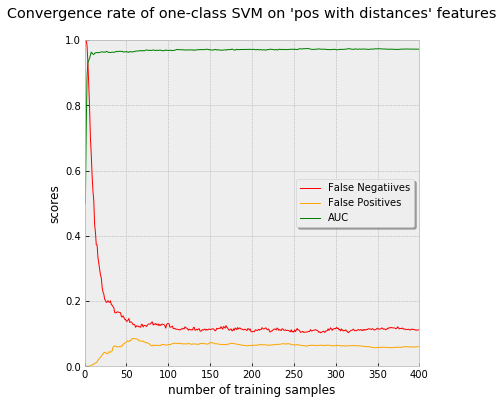

In [21]:
# plot the FN and FP scores as two lines
plotErrorToSampleCounts(samples_OCSVM, scores_FN_OCSVM, scores_FP_OCSVM, scores_AUC_OCSVM,
                        name_of_selected_features_set, 
                        clf_OCSVM_name, 
                        num_train_positive_samples,
                        saving_path='')

# save the FN and FP scores plot as two lines
plotErrorToSampleCounts(samples_OCSVM, scores_FN_OCSVM, scores_FP_OCSVM, scores_AUC_OCSVM,
                        name_of_selected_features_set, 
                        clf_OCSVM_name, 
                        num_train_positive_samples,
                        saving_path=img_save_path)

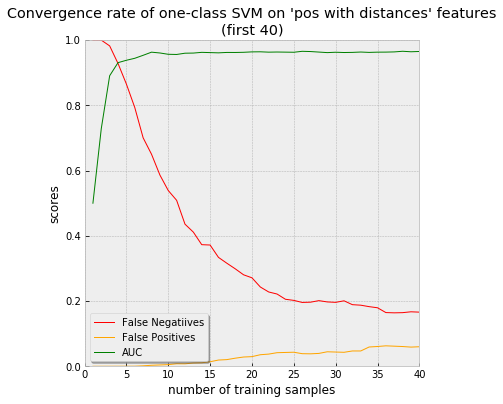

In [22]:
# plot the FN and FP scores as two lines (LOW RES)
plotErrorToSampleCounts(samples_OCSVM, scores_FN_OCSVM, scores_FP_OCSVM, scores_AUC_OCSVM,
                        name_of_selected_features_set, 
                        clf_OCSVM_name, 
                        40,
                        zoom=zoom,
                        saving_path='')

# save the FN and FP scores plot as two lines (LOW RES)
plotErrorToSampleCounts(samples_OCSVM, scores_FN_OCSVM, scores_FP_OCSVM, scores_AUC_OCSVM,
                        name_of_selected_features_set, 
                        clf_OCSVM_name, 
                        40,
                        zoom=zoom,
                        saving_path=img_save_path)

### Run the Models - Isolation Forest

In the next cell we will be running the models for Isolation Forest in line with all the previous specifications, and then we will put the plots in the graph.

In [23]:
# initialize the sumber of samples
samples_IF = list(range(1, num_train_positive_samples+1))
#samples_IF = list(range(1, 41))

# select a repetitions parameter for the time each point is calculated
reps_IF = 4

# get the FN and FP scores
scores_FN_IF, scores_FP_IF, scores_AUC_IF = \
                        findConvergencePoints(X_pos.loc[:, selected_features_set],
                                              X_neg.loc[:, selected_features_set],
                                              samples_IF,
                                              clf_IF,
                                              num_test_positive_samples,
                                              reps_IF)

-- tracker: Working on training sample size of 400


In [24]:
scores_FN_IF = [score*0.01 for score in scores_FN_IF]
scores_FP_IF = [score*0.01 for score in scores_FP_IF]

# make a dataframe out of the data to log it
scores_IF_df = pd.DataFrame({'samples': samples_IF,
                             'FN_score': scores_FN_IF,
                             'FP_score': scores_FP_IF,
                             'AUC_score': scores_AUC_IF})

# save the df
scores_IF_df.to_csv(logs_path + "convergence experiment with Giorgos data on {} and '{}' features.csv"
                    .format(clf_IF_name, name_of_selected_features_set), index=False)

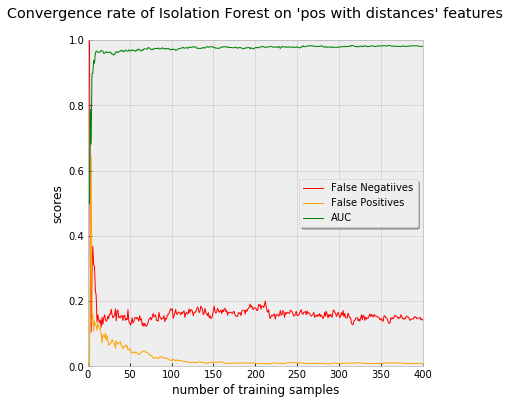

In [25]:
# plot the FN and FP scores as two lines
plotErrorToSampleCounts(samples_IF, scores_FN_IF, scores_FP_IF, scores_AUC_IF,
                        name_of_selected_features_set, 
                        clf_IF_name, 
                        num_train_positive_samples,
                        saving_path='')

# save the FN and FP scores plot as two lines
plotErrorToSampleCounts(samples_IF, scores_FN_IF, scores_FP_IF, scores_AUC_IF,
                        name_of_selected_features_set, 
                        clf_IF_name, 
                        num_train_positive_samples,
                        saving_path=img_save_path)

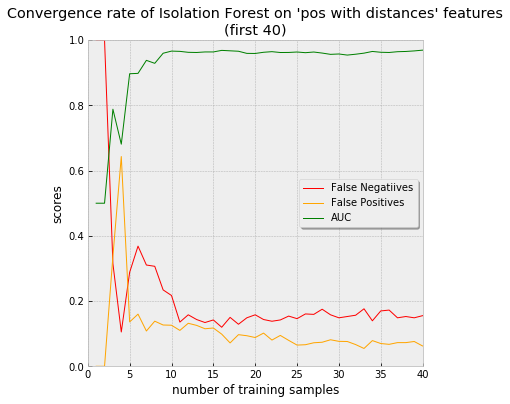

In [26]:
# plot the FN and FP scores as two lines (LOW RES)
plotErrorToSampleCounts(samples_IF, scores_FN_IF, scores_FP_IF, scores_AUC_IF,
                        name_of_selected_features_set, 
                        clf_IF_name, 
                        40,
                        zoom=zoom,
                        saving_path='')

# save the FN and FP scores plot as two lines (LOW RES)
plotErrorToSampleCounts(samples_IF, scores_FN_IF, scores_FP_IF, scores_AUC_IF,
                        name_of_selected_features_set, 
                        clf_IF_name, 
                        40,
                        zoom=zoom,
                        saving_path=img_save_path)